In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import numpy as np
from tqdm import tqdm

In [283]:
metadata = pd.read_csv('dataset/BraTS20 Training Metadata.csv')
metadata.head()

,slice_path,target,volume,slice,label0_pxl_cnt,label1_pxl_cnt,label2_pxl_cnt,background_ratio
0,../input/brats2020-training-data/BraTS2020_tra...,0,41,0,0,0,0,1.0
1,../input/brats2020-training-data/BraTS2020_tra...,0,41,1,0,0,0,1.0
2,../input/brats2020-training-data/BraTS2020_tra...,0,41,2,0,0,0,1.0
3,../input/brats2020-training-data/BraTS2020_tra...,0,41,3,0,0,0,1.0
4,../input/brats2020-training-data/BraTS2020_tra...,0,41,4,0,0,0,1.0


In [284]:
ill_slices = metadata[metadata['target'] == 1]
ill_slices.head()

,slice_path,target,volume,slice,label0_pxl_cnt,label1_pxl_cnt,label2_pxl_cnt,background_ratio
25,../input/brats2020-training-data/BraTS2020_tra...,1,41,25,0,0,5,0.999913
26,../input/brats2020-training-data/BraTS2020_tra...,1,41,26,3,0,41,0.999236
27,../input/brats2020-training-data/BraTS2020_tra...,1,41,27,63,0,96,0.997240
28,../input/brats2020-training-data/BraTS2020_tra...,1,41,28,127,0,136,0.995434
29,../input/brats2020-training-data/BraTS2020_tra...,1,41,29,183,0,169,0.993889


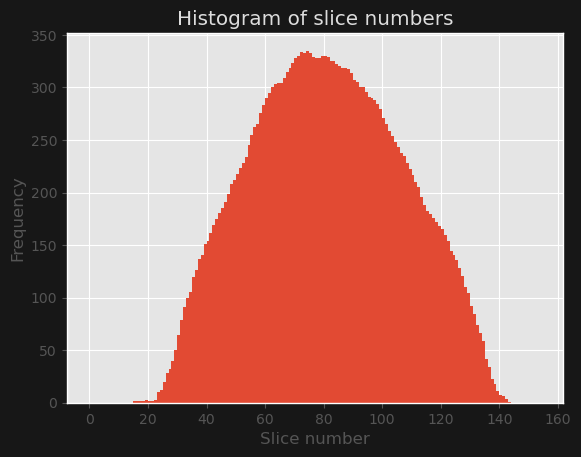

In [285]:
# Plot a histogram of slice numbers
plt.hist(ill_slices['slice'], bins=[i for i in range(0, 155)])
plt.xlabel('Slice number')
plt.ylabel('Frequency')
plt.title('Histogram of slice numbers')
plt.show()

In [286]:
# Group by slice number and count the number of slices in each group
ill_slice_counts = ill_slices.sort_values('slice').groupby('slice').size()
ill_slice_counts.head()

slice
15    2
16    2
17    2
18    2
19    3
dtype: int64

In [287]:
# Get the total number of slices per slice number
total_slices = metadata.groupby('slice').size()
total_size_per_slice_number = total_slices.iloc[0]
total_size_per_slice_number

369

In [288]:
# Find a interval on slice number with length 20 that contains at least 400 corresponding healthy slices
candidate_intervals = []
for i in ill_slice_counts.index:
    if i+20 > 155:
        break
    slice_sum = 0
    for j in range(i, i+20):
        if j in total_slices.index:
            slice_sum += total_size_per_slice_number - ill_slice_counts.get(j, 0)
            # print(ill_slice_counts.get(j, 0))
    if slice_sum > 400:
        candidate_intervals.append((i, i+20, slice_sum))
        


In [289]:
mean_background_ratio_per_slice = metadata.groupby('slice')['background_ratio'].mean()
mean_background_ratio_per_slice.head()

slice
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: background_ratio, dtype: float64

In [290]:
# Find the interval with minimum sum of mean background ratio among the candidate intervals
min_sum = float('inf')
min_interval = None
for interval in candidate_intervals:
    start, end, _ = interval
    sum_ratio = mean_background_ratio_per_slice.iloc[start:end].sum()
    if sum_ratio < min_sum:
        min_sum = sum_ratio
        min_interval = interval

min_interval

(73, 93, 931)

In [291]:
# Directory containing .h5 files
directory = "./dataset/BraTS2020_training_data/content/data" # Relative path to the dataset directory

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")
# The name of the files is in "volume_xxx_slice_yyy.h5" format, xxx(volumn number) in [1, 369], yyy(slice number) in [0, 154]

# Order the files by volume number and slice number
h5_files.sort(key=lambda x: (int(x.split('_')[1]), int(x.split('_')[3].split('.')[0])))
print(f"Sorted file names:\nExample file names:{h5_files[:10]}")

Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']
Sorted file names:
Example file names:['volume_1_slice_0.h5', 'volume_1_slice_1.h5', 'volume_1_slice_2.h5', 'volume_1_slice_3.h5', 'volume_1_slice_4.h5', 'volume_1_slice_5.h5', 'volume_1_slice_6.h5', 'volume_1_slice_7.h5', 'volume_1_slice_8.h5', 'volume_1_slice_9.h5']


In [292]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title="Image"):
    # Assuming image has 3 channels and is normalized between 0 and 1
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(image[:,:,i], cmap='gray')
        ax.title.set_text(f'{title} Channel {i+1}')
    plt.show()

def display_mask(mask, title="Mask"):
    import matplotlib.pyplot as plt
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.show()

In [293]:
def load_metadata_within_interval(metadata, start, end):
    metadata_within_interval = metadata[(start <= metadata['slice']) & (metadata['slice'] < end)]
    return metadata_within_interval

def get_file_names(metadata, target):
    file_names = metadata[metadata['target'] == target]['slice_path'].values
    file_names = [os.path.basename(file_name) for file_name in file_names]
    return file_names

def split_files(file_names, train_ratio):
    np.random.seed(114514)
    file_names_shuffle = np.array(file_names)
    np.random.shuffle(file_names_shuffle)
    train_size = int(train_ratio * len(file_names))
    train_files = file_names[:train_size]
    test_files = file_names[train_size:]
    return train_files, test_files

metadata_within_interval = load_metadata_within_interval(metadata, 80, 100)
healthy_slices_file_names = get_file_names(metadata_within_interval, 0)
print(f"Number of healthy slices: {len(healthy_slices_file_names)}")
unhealthy_slices_file_names = get_file_names(metadata_within_interval, 1)

healthy_train_files, healthy_test_files = split_files(healthy_slices_file_names, 0.8)
unhealthy_test_files = unhealthy_slices_file_names

print(f"Number of healthy training files: {len(healthy_train_files)}")
print(f"Number of healthy testing files: {len(healthy_test_files)}")
print(f"Number of unhealthy testing files: {len(unhealthy_test_files)}")
print(f"Total number of healthy files: {len(healthy_train_files) + len(healthy_test_files)}")


Number of healthy slices: 1218
Number of healthy training files: 974
Number of healthy testing files: 244
Number of unhealthy testing files: 6162
Total number of healthy files: 1218


In [294]:
def load_data_from_file_names(file_names, i_dir, o_dir, o_file_name, type='image', total_number=-1):
    if type == 'image':
        data = np.zeros((len(file_names[:total_number]), 240, 240, 3), dtype=np.float32)
    elif type == 'mask':
        data = np.zeros((len(file_names[:total_number]), 240, 240), dtype=bool)
    else:
        raise ValueError(f"Invalid type: {type}")

    for i, file_name in (enumerate(tqdm(file_names[:total_number]))):
        file_path = os.path.join(i_dir, file_name)
        with h5py.File(file_path, 'r') as file:
            if type == 'image':
                temp_img = file['image'][()][:, :, [0, 2, 3]]  # Assuming image data is in a suitable dtype
                # Normalize the image data
                temp_img = temp_img.astype(np.float32)  # Ensure it's float32
                min_val = np.min(temp_img)
                max_val = np.max(temp_img)
                if max_val > min_val:  # Avoid division by zero
                    data[i] = (temp_img - min_val) / (max_val - min_val)
                else:
                    data[i] = temp_img
            elif type == 'mask':
                temp = file['mask'][()]
                data[i] = np.logical_or.reduce(temp, axis=2)
            else:
                raise ValueError(f"Invalid type: {type}")

    np.save(os.path.join(o_dir, o_file_name), data)

    # Load the data and plot several slices to verify the data
    data = np.load(os.path.join(o_dir, o_file_name))
    print(f"Loaded data shape: {data.shape}")
    for i in range(3):
        if type == 'image':
            display_image_channels(data[i], title='Example Image Channels')
        elif type == 'mask':
            display_mask(data[i], title='Example Mask')
    
    # Delete data to save memory
    del data

100%|██████████| 973/973 [00:05<00:00, 164.98it/s]


Loaded data shape: (973, 240, 240, 3)


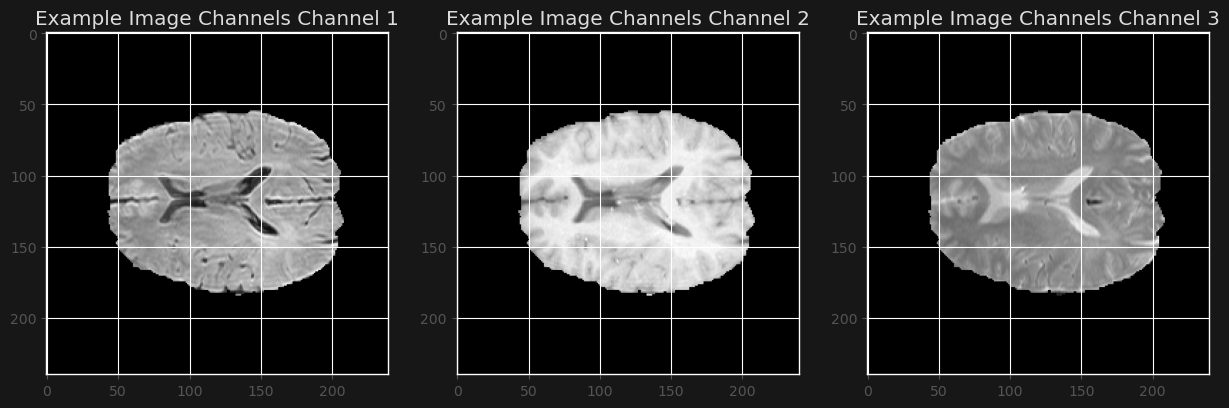

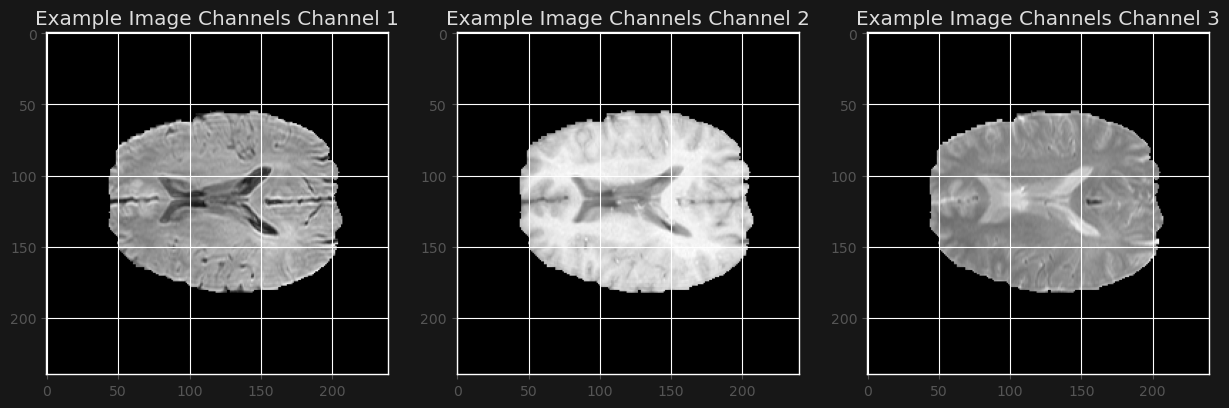

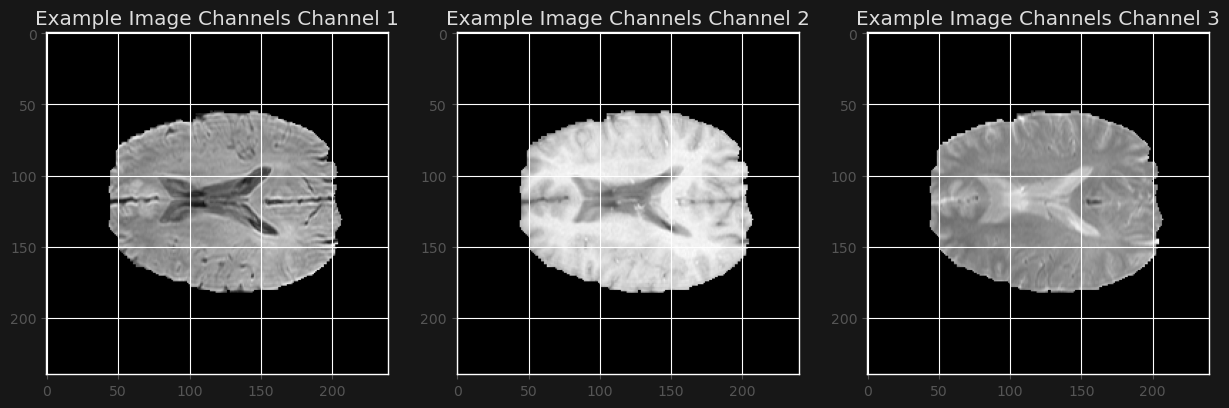

In [295]:
# Load all data and store it in ./data/ as .npy files
load_data_from_file_names(healthy_train_files, directory, './data/train', 'healthy_train_images.npy', type='image')


100%|██████████| 243/243 [00:01<00:00, 170.01it/s]


Loaded data shape: (243, 240, 240, 3)


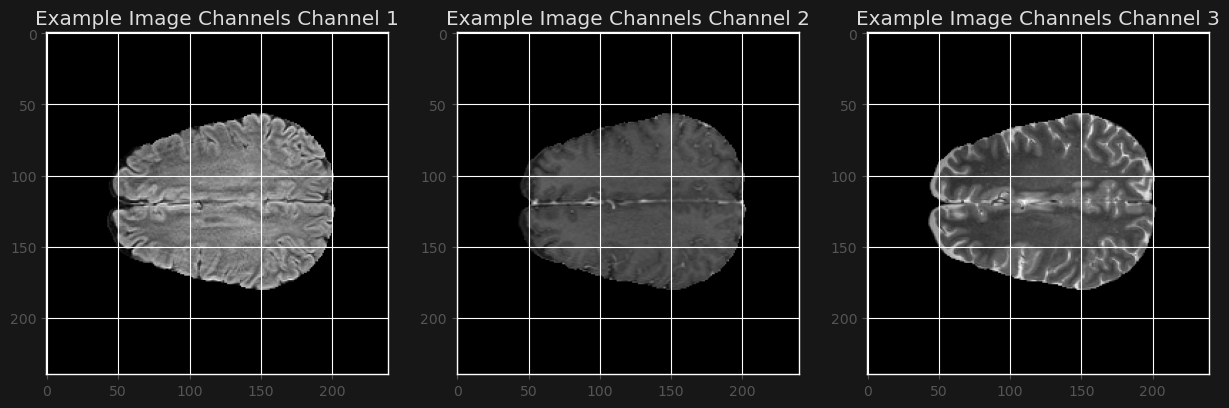

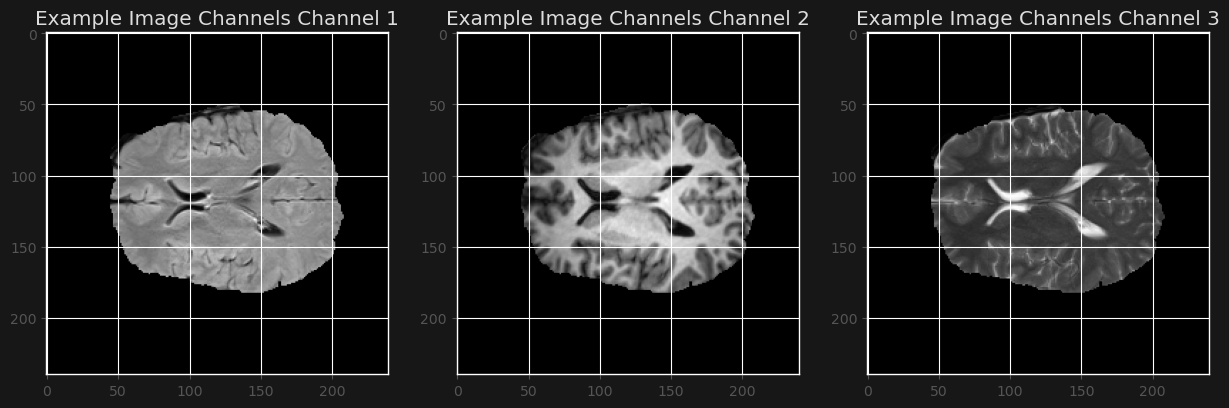

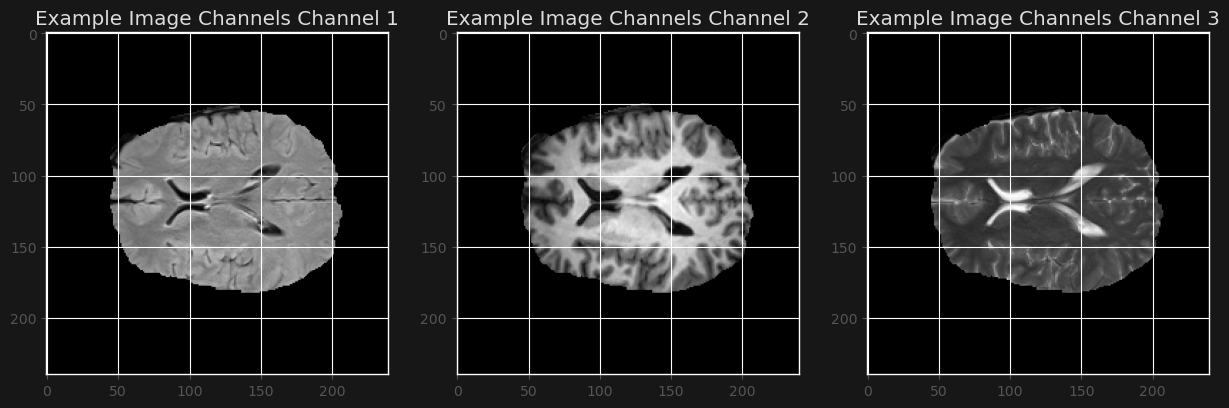

In [296]:
load_data_from_file_names(healthy_test_files, directory, './data/test', 'healthy_test_images.npy', type='image')


100%|██████████| 244/244 [00:01<00:00, 150.66it/s]


Loaded data shape: (244, 240, 240, 3)


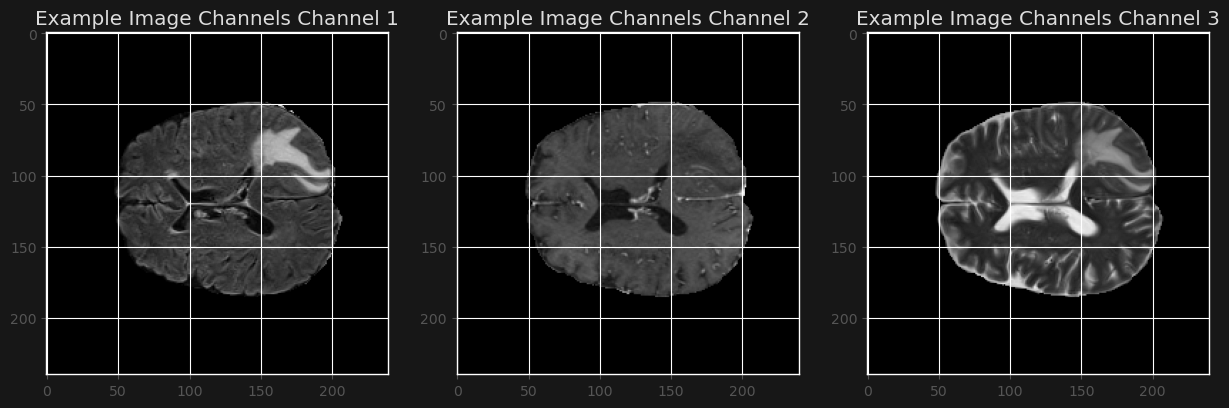

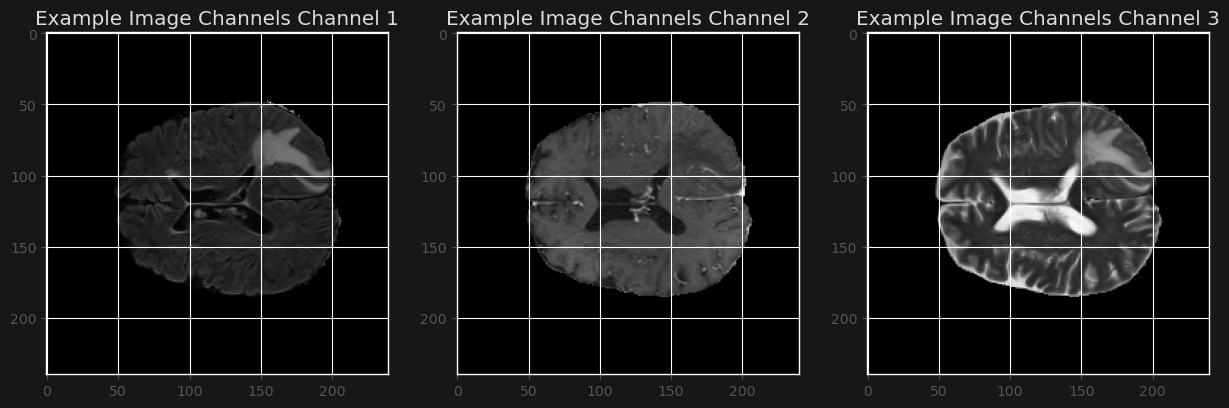

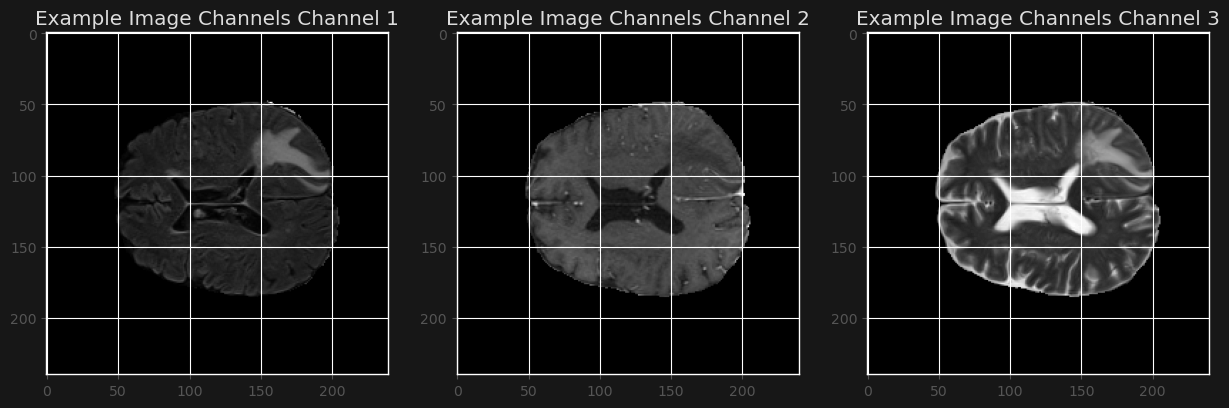

In [297]:
load_data_from_file_names(unhealthy_test_files, directory, './data/test', 'unhealthy_test_images.npy', type='image', total_number=len(healthy_test_files))


100%|██████████| 244/244 [00:00<00:00, 570.51it/s]


Loaded data shape: (244, 240, 240)


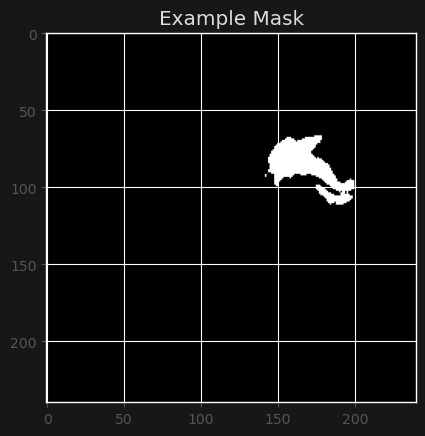

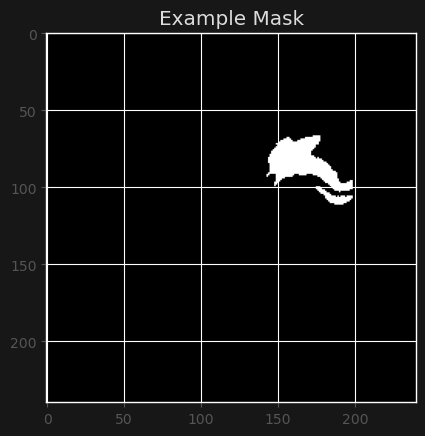

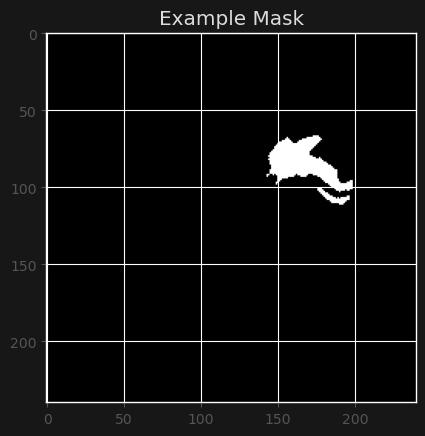

In [298]:
load_data_from_file_names(unhealthy_test_files, directory, './data/test', 'unhealthy_test_masks.npy', type='mask', total_number=len(healthy_test_files))
